# MMRDNS Matches

## Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm
from kerr.models import mmrdns as ns
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
from positive.maths import lim
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Select and Load NR Data

In [2]:
# Find simlations to load 
# A = scsearch(keyword='q10c25e_T_112_448',verbose=True,nonspinning=True, apply_remnant_fit=True)
# A = scsearch(keyword='D11_q1.00_a0.0_m240',verbose=True, apply_remnant_fit=True)
# A = scsearch(keyword='q18a0a0c025_144',verbose=True, apply_remnant_fit=True)
# A = scsearch(keyword='q4a0_T_112_448',verbose=True, apply_remnant_fit=True)
A = scsearch(keyword='hrq',q=2,nonspinning=True,apply_remnant_fit=True)
# A = scsearch(keyword='D10_q6.00_a0.00_0.00_m280',nonspinning=True,verbose=True, apply_remnant_fit=True)
# A = scsearch(institute='bam',nonspinning=True,apply_remnant_fit=True,verbose=True)

In [3]:
# Load simulation data
a = A[0]
lm = []
for ll,mm in [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5)]: # 
    lm += [ (ll,mm), (ll,-mm) ]
# y = gwylm( a, lm=lm, clean=True, verbose=True )
y = gwylm( a, lmax=5, clean=True, verbose=True, pad=100 )

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.15) keyword.
(gwylm)>> Found lmax (=5) keyword.
(gwylm)>> Found pad (=100) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10bb84b90>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/GT-MAYA/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (

## Matches with TIME DOMAIN model (call time domain LAL functions and then take DFFTs)

#### Create list of ringdown frequencies in physical units to use for future reference

In [4]:
cwmap = { (l,m,n):leaver(y.xf,l,m,n,Mf=y.mf)[0] for l,m,n in ns.lmn }

#### Select NR TD Ringdown

(ringdown)>> Time will be listed relative to the peak of luminosity.


([<matplotlib.axes._subplots.AxesSubplot at 0x1112323d0>,
 <matplotlib.figure.Figure at 0x10b8e0410>)

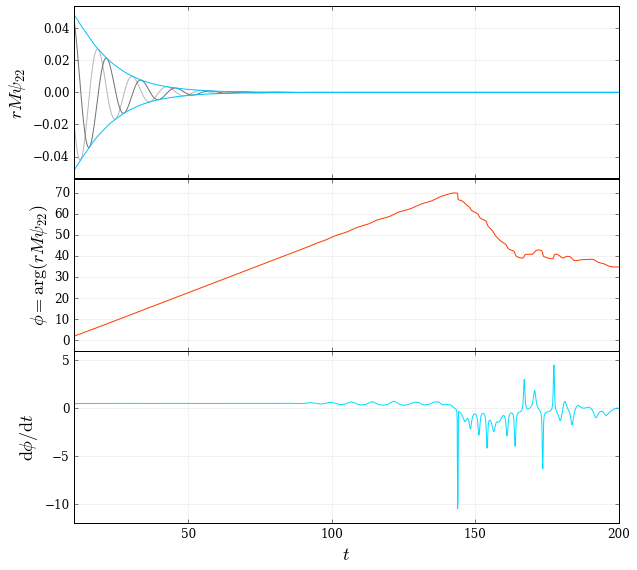

In [5]:
yrd = y.ringdown(T0=10,T1=200,use_peak_strain=False,verbose=True)
close('all')
yrd.lm[2,2]['psi4'].plot()

#### Define Physical Extrensic Parameters

In [6]:

# 
M_Sol = 100
Mf_Sol = 1.00002821*M_Sol * y.mf
D_Mpc = 150
inclination = 1.83
fmin = 100
phi_ref = 0 # pi/3
#
M = M_Sol*MSUN_SI
Mf = Mf_Sol*MSUN_SI
D = D_Mpc*1.0e6*PC_SI
#
t_code = yrd.lm[2,2]['strain'].t
deltaT = physt( diff(t_code)[0], M_Sol )
t = physt( t_code, M_Sol )
xf = y.xf
eta = y.eta
#
fmap = array([physf( cwmap[k].real/(2*pi), M_Sol ) for k in cwmap])
# print lim(abs(fmap))
#
df = physf( yrd.lm[2,2]['strain'].df, M_Sol )
code_f = yrd.lm[2,2]['strain'].f
f  = physf( code_f, M_Sol )

#
fmin,fmax=30.0,1500.0
fmask = (f>=fmin) & (f<=fmax)

#### Construct and test high-level waveform wrappmers

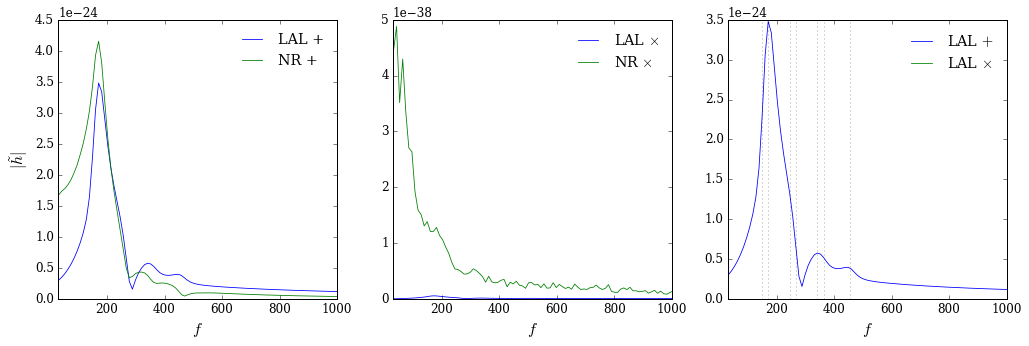

In [15]:

#
def signal_wfarr_fun( THETA,PHI,LM=None) : 
    ans = physhf( yrd.recompose( THETA,PHI,kind='strain',domain='freq').fd_wfarr[fmask,:], M_Sol, D_Mpc ) 
    return ans

#
def template_wfarr_fun( THETA,PHI,LM=None):
    # Import useful things 
    from numpy.fft import fft,fftshift
    # Evaluate LAL model in time domain
    hlal_raw = lalsim.SimRingdownMMRDNS_time(0.0,deltaT,len(t_code),Mf,xf,eta,THETA,PHI,D,nonGRparams=None)
    hp = hlal_raw[0].data.data
    hc = hlal_raw[1].data.data
    # Convert to frequency domain
    #hfp = fftshift( fft( hp ) )
    #hfc = fftshift( fft( hc ) )
    hfp = deltaT * fftshift( fft( hp ) )
    hfc = deltaT * fftshift( fft( hc ) )
    # Construct answer 
    f_ = physf( yrd.lm[2,2]['strain'].f, M_Sol )
    ans = array( [ f_, hfp, hfc ] ).T[fmask,:]
    # Return answer
    return ans

#
theta,phi = pi/2, 0
template = template_wfarr_fun( theta, phi )
signal =   signal_wfarr_fun(   theta, phi )

#
figure( figsize=5*array([3.4,1]) )

#
def plotqnm(l,m,label):
    axvline( physf(cwmap[l,m,0]/(2*pi),M_Sol), linestyle=':', label=label, color=zeros(3), alpha=0.4 )

#
def plotpc(data,k=1,label='LAL'):
    xl = [30,1000]
    plot( f[fmask], abs(data[:,k]), label=label )
    xlim(xl)
    legend(frameon=False)
    xlabel('$f$')

#
subplot(1,3,1)
plotpc(template,1,'LAL +')
plotpc(signal,1,'NR +')
ylabel(r'$|\tilde{h}|$')
#
subplot(1,3,2)
plotpc(template,2,r'LAL $\times$')
plotpc(signal,2,r'NR $\times$')
#
subplot(1,3,3)
plotpc(template,1,r'LAL $+$')
plotpc(template,2,r'LAL $\times$')
[ plotqnm(l,m,'(%i,%i,0)'%(l,m)) for l,m in [(2,2),(3,3),(2,1),(3,2),(4,3),(4,4),(5,5)] ];


#### Initialize match object and plot waveforms on noise curve

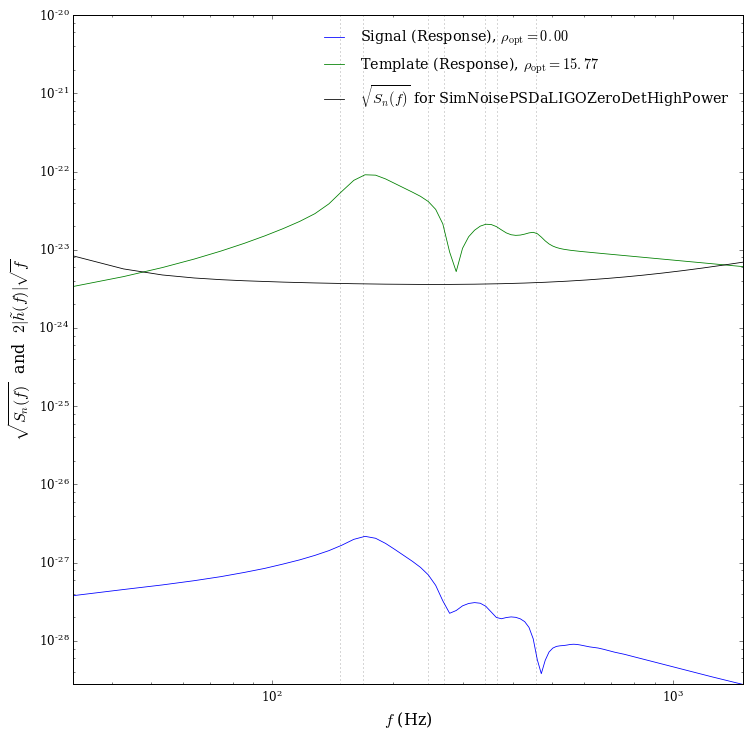

In [16]:
#--%--%--%--%--%--%--%--%--%--%--%--#
# Construct match object
#--%--%--%--%--%--%--%--%--%--%--%--#
mo = match_object( template, signal, fmin=fmin, fmax=fmax, signal_polarization=pi/4, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
mo.plot()
[ plotqnm(l,m,'(%i,%i,0)'%(l,m)) for l,m in [(2,2),(3,3),(2,1),(3,2),(4,3),(4,4),(5,5)] ];

/Library/Python/2.7/site-packages/scipy/interpolate/fitpack2.py:595: ComplexWarning: Casting complex values to real discards the imaginary part
  xb=bbox[0],xe=bbox[1],s=0)



Result of notebook for-loop method:
----------------------------------------


/Library/Python/2.7/site-packages/matplotlib/lines.py:1082: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markeredgecolor != ec:
/Library/Python/2.7/site-packages/ipykernel/__main__.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


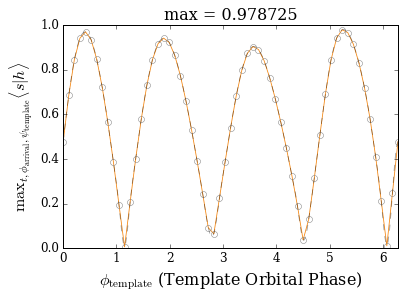


Result of class method:
----------------------------------------
NOTE: This method uses intrp_max to get a better peak location.


/Library/Python/2.7/site-packages/scipy/interpolate/fitpack2.py:181: ComplexWarning: Casting complex values to real discards the imaginary part
  xb=bbox[0],xe=bbox[1],s=s)
/Library/Python/2.7/site-packages/matplotlib/transforms.py:993: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval
/Library/Python/2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:
/Users/book/JOKI/Libs/KOALA/nrutils_dev/nrutils/analyze/match.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  pp.title('max = %f'%match )


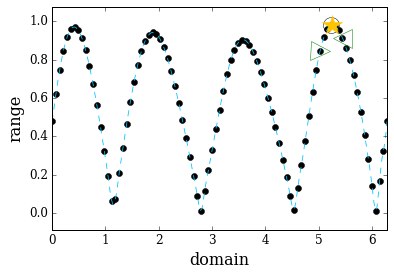

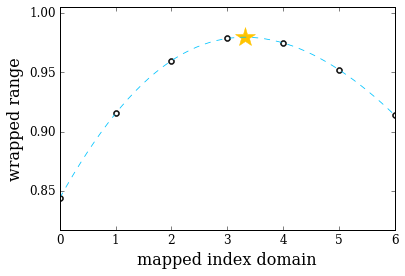

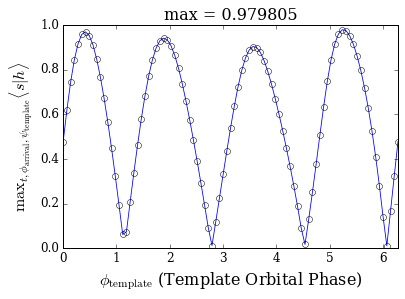

In [17]:
figure()
    
phi_range = linspace(0,2*pi,61)
# print 'yo! --> ',physf(y.ylm[0].df,M)
# template_wfarr_fun = lambda PHI: physhf( z.recompose(theta, PHI, select_lm=select_lm), M, D ) 
template_phi_wfarr_fun = lambda PHI: template_wfarr_fun( theta, PHI )
# template_phi_wfarr_fun = lambda PHI: lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],theta,PHI,D,phys_df,fmin,fmax )


# 
matchlist = []
for phi in phi_range:
    # 
    mo.apply( template_wfarr = template_phi_wfarr_fun(phi) )
    matchlist.append(  mo.brute_match(timeoptoff=True) )
    # matchlist.append(  mo.calc_template_pol_optimized_match() )

#
print '\nResult of notebook for-loop method:\n%s'%(20*'--')

plot( phi_range, matchlist, marker='o', color='#f48713', mfc='none', mec=0.5*ones(3) )
phi_ = linspace(0,2*pi,2e2)
plot( phi_, spline(phi_range,matchlist)(phi_), '--k', alpha=0.4 )
    
xlabel(r'$\phi_{\mathrm{template}}$ (Template Orbital Phase)')
xlim(lim(phi_))
# title('$\psi_{\mathrm{signal}} = %1.2f$'%mo.signal['polarization'])
ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
title('max = %f'%max(matchlist) )
# title(r'Optimized over $\psi_{\mathrm{template}}$')
show()

print '\nResult of class method:\n%s\nNOTE: This method uses intrp_max to get a better peak location.'%(20*'--')
mo.calc_template_phi_optimized_match( template_phi_wfarr_fun, method='numerical', timeoptoff=True, plot=True );

In [19]:
match_info = mo.calc_match_sky_moments( signal_wfarr_fun,
                                        template_wfarr_fun, 
                                        N_theta = 9, 
                                        N_psi_signal = 8, 
                                        N_phi_signal = 8,
                                        method = 'numerical',
                                        timeoptoff = True,
                                        verbose = True )

 (calc_match_sky_moments)>> theta = 0.01
----------------------------------------
>> working  . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . ,  done.
>>  min_match 	 = 	 0.999974
>>  avg_match 	 = 	 0.999991
snr_avg_match 	 = 	 0.999991
>>  max_match 	 = 	 0.999996
----------------------------------------
(calc_match_sky_moments)>> theta = 0.40
----------------------------------------
>> working  . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . ,  done.
>>  min_match 	 = 	 0.999479
>>  avg_match 	 = 	 0.999832
snr_avg_match 	 = 	 0.999839
>>  max_match 	 = 	 0.999941
----------------------------------------
(calc_match_sky_moments)>> theta = 0.79
----------------------------------------
>> working  . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . . , . . . . . . . 

## Plot matches

In [20]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

(mkdir)>> Directory at "/Users/book/Desktop/D9_q2.0_a0.0_m160/data/" does not yet exist and will be created.
[ 0.00098058  0.00100011]


NameError: name 'NOTEBOOK_FULL_PATH' is not defined

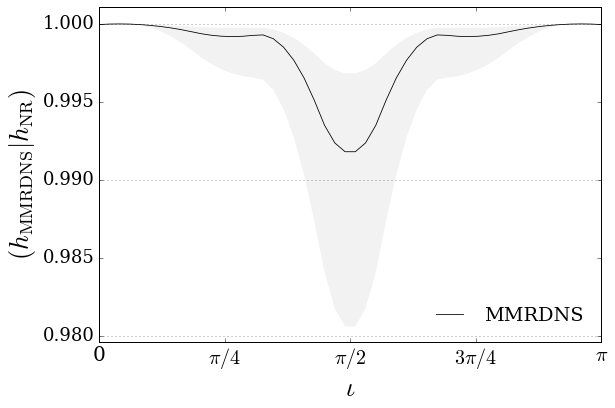

In [21]:
import pickle

#
outdir = '/Users/book/Desktop/'+y.simname+'/'
datadir = outdir + 'data/'
mkdir(datadir,verbose=True)

#
filepath = datadir + 'match_info.pickle'


# with open( '/Users/book/GARREG/REPOS/PhenomHM/workflows/matches/data/q2_-0.5_-0.5_96_460/data/match_info.pickle' , 'rb') as datafile:
#     match_info = pickle.load( datafile )

#
with open(filepath, 'wb') as datafile:
    pickle.dump( match_info , datafile, pickle.HIGHEST_PROTOCOL )

# #
# for k in match_info:
#     savetxt( datadir+k+'.asc', match_info[k] )
    

# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 20    
    
a = match_info

figure( figsize = 6*array([1.5,1]) )

#
alpha = 0.05
sth = linspace(0,pi)
sm = lambda x: spline( a['theta'], a[x], k=2 )(sth)
fill_between( sth, sm('min'), sm('max'), color='k', alpha=alpha, edgecolor='none' )
# fill_between( sth, sm('quadrupole_min'), sm('quadrupole_max'), color='k', alpha=alpha, edgecolor='none' )
plot( sth, sm('weighted_avg'),'-k',label='MMRDNS' )
# plot( sth, sm('quadrupole_weighted_avg'),'--k',label='PhenomD' )


#
hline = [0.97,0.98,0.99,1.0]
for val in hline:
    axhline(val,linestyle=':',color='k',alpha=0.5)

#
xlim([0,pi])
legend( frameon=False, loc=4 )
    
#
xtk_labels =    [ '0',  r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$' ]
xtk = pi*array( [  0,   1.0/4,      1.0/2,      3.0/4,       1  ] )
xticks(xtk,xtk_labels)
gca().tick_params(axis='y', which='major', labelsize=18)
gca().tick_params(axis='x', which='major', labelsize=20)
    
xlim( [0,pi] )
xlabel(r'$\iota$')
# ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
ylabel(r'$( h_\mathrm{MMRDNS} | h_\mathrm{NR} )$')

# gca().yaxis.set_label_position("right")
# gca().yaxis.tick_right()

yl = lim( hstack([sm('min'),sm('max')]) )
dy = 0.001*yl
print dy
ylim( yl + dy*array([-1,1]) )

# title(y.simname)

savefig( outdir+'matches_'+y.simname+'_ALL_NR_MULTIPOLES.pdf',bbox_inches='tight' )

#
from shutil import copyfile
src = '/Users/book'+NOTEBOOK_FULL_PATH
print src
dst = outdir + 'notebook_used_for_%s.ipynb'%y.simname
copyfile(src, dst)


In [ ]:
hist( match_info['samples']['match'],15 )

In [ ]:
hist( match_info['samples']['optsnr'], 15 )

In [ ]:
match_info['samples'].keys()

In [ ]:

#
import corner

#
X = array( [ match_info['samples']['optsnr'],  
             match_info['samples']['phi_signal'],  
             match_info['samples']['psi_signal'],  
             match_info['samples']['theta'], 
             match_info['samples']['match']] ).T
print X.shape



In [ ]:
c = corner.corner( X, range=[ lim(X[:,k],dilate=0.05) for k in range(X.shape[-1]) ], 
                   bins=50,quantiles=[0.16, 0.5, 0.84],
                   labels=[ r'$\langle s | h \rangle$', 
                            r'$\phi_s$', 
                            r'$\psi_s$',
                            r'$\iota_s$',
                            r'$\rho_{\mathrm{opt}}$' ],
                   show_titles=True )
c.set_size_inches( 13*array([1,1]) )

# c.axes[3].set_ylabel(r'$\iota$')

# c.axes[6].set_xlabel(r'$\rho_{\mathrm{opt}}$')
# c.axes[6].set_ylabel(r'$\langle s_{\mathrm{NR}} | h_{\mathrm{LAL}} \rangle$')

# c.axes[7].set_xlabel(r'$\iota$')
# c.axes[8].set_xlabel(r'$\langle s_{\mathrm{NR}} | h_{\mathrm{LAL}} \rangle$')

savefig( outdir+'matches_'+y.simname+'_corner.pdf',bbox_inches='tight' )